<a href="https://colab.research.google.com/github/fauxneticien/scriptable_hubert_encoder/blob/main/01_repo_walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Repository walkthrough: scriptable_hubert_encoder

This repository aims to create a scriptable HuBERT encoder to examine if/how well [cramming strategies](https://github.com/JonasGeiping/cramming) proposed for the original BERT encoder can help reduce the compute footprint needed to pretrain HuBERT models for low-resource scenarios.

## Setup

In [1]:
%%capture
%%bash

# Setup Colab
if [ -n "$COLAB_RELEASE_TAG" ]; then
  rm -rf ./*
  curl -f https://raw.githubusercontent.com/fauxneticien/scriptable_hubert_encoder/main/setup-colab.sh | bash
fi

## Repository contents

At the top level, there will be various `ipynb` Notebook/Colabs each exploring/setting up one or some (related) set of features of the HuBERT encoder.

### `./components`

In the `components` folder there are two main files, `verbatim_torchaudio.py` and `scriptable.py` which each contain more or less the same set of components needed to build a HuBERT model (e.g. `class Encoder`, etc.).

The code in `verbatim_torchaudio.py` is a subset of classes from the torchaudio repository (the 2.0.2 release version) and **should not be modified**. We'll create scriptable versions of these classes in `scriptable.py`.

### `./data/mini-librispeech`

In the `data` folder, there is a pre-prepared `mini-librispeech` dataset, which we will explore in the next section.

In [2]:
!tree

.
├── 01_repo_walkthrough.ipynb
├── components
│   ├── __init__.py
│   ├── model.py
│   ├── scriptable.py
│   └── verbatim_torchaudio.py
├── data
│   └── mini-librispeech
│       ├── dev-clean-2
│       │   ├── cuts.000000.jsonl.gz
│       │   ├── cuts.000001.jsonl.gz
│       │   ├── cuts.000002.jsonl.gz
│       │   ├── cuts.000003.jsonl.gz
│       │   ├── cuts.000004.jsonl.gz
│       │   ├── fbank.000000.tar
│       │   ├── fbank.000001.tar
│       │   ├── fbank.000002.tar
│       │   ├── fbank.000003.tar
│       │   ├── fbank.000004.tar
│       │   ├── ptlabel.000000.tar
│       │   ├── ptlabel.000001.tar
│       │   ├── ptlabel.000002.tar
│       │   ├── ptlabel.000003.tar
│       │   └── ptlabel.000004.tar
│       ├── mini-librispeech.tgz
│       └── train-clean-5
│           ├── cuts.000000.jsonl.gz
│           ├── cuts.000001.jsonl.gz
│           ├── cuts.000002.jsonl.gz
│           ├── cuts.000003.jsonl.gz
│           ├── cuts.000004.jsonl.gz
│           ├── cuts.000005.jsonl.gz

## mini-librispeech

The `mini-librispeech` is a roughly 5-hour subset of the [960-hour LibriSpeech](https://www.openslr.org/12) ASR training dataset created from various demos by [Lhotse](https://github.com/lhotse-speech/lhotse) a speech data processing/loading library for speech-related ML tasks.

### Inspecting a 'Cut'

In Lhotse's terminology, a `Cut` is basically a snippet/utterance of audio and a `Recording` is a longer audio file which can have many `Cuts`. Hence when we're loading the data, we're listing the various files contained in the `mini-librispeech` folder into a `CutSet` (i.e. a set of `Cuts`).

The `from_shar` part corresponds to their custom data sharding feature which stores various raw data/derived features/training targets as plain `.tar` files whose indexed contents can be quickly loaded into memory.

<img width="800px" src="https://raw.githubusercontent.com/lhotse-speech/lhotse/master/docs/lhotse-cut-illustration.png">

List files in `data/mini-librispeech/train-clean-5` and load into a `CutSet`

In [3]:
from pathlib import Path
from lhotse import CutSet

train_data_dir = Path('data/mini-librispeech/train-clean-5')

train_cuts = CutSet.from_shar(fields={
    'cuts': sorted(list(train_data_dir.glob("cuts.*.jsonl.gz"))),
    'fbank': sorted(list(train_data_dir.glob("fbank.*.tar"))),
    'ptlabel': sorted(list(train_data_dir.glob("ptlabel.*.tar")))
})

Fetch the first cut in the CutSet

In [4]:
first_cut = train_cuts[0]

first_cut

MonoCut(id='118-47824-0000-0', start=0, duration=15.01, channel=0, supervisions=[SupervisionSegment(id='118-47824-0000', recording_id='118-47824-0000', start=0.0, duration=15.01, channel=0, text="CHAPTER SEVEN THE AMAZING MEETING IN THE SHADOWS OF THE OLD COURTYARD BOBBY RETURNED TO HIS BED HE LAY THERE STILL SHIVERING BENEATH THE HEAVY BLANKETS I DON'T DARE HE ECHOED GRAHAM'S WORDS THERE'S NOTHING ELSE ANY ONE CAN SAY", language='English', speaker='118', gender=None, custom=None, alignment=None)], features=None, recording=Recording(id='118-47824-0000', sources=[AudioSource(type='shar', channels=[0], source='')], sampling_rate=16000, num_samples=240160, duration=15.01, channel_ids=[0], transforms=None), custom={'fbank': TemporalArray(array=Array(storage_type='memory_lilcom', storage_path='', storage_key='<binary-data>', shape=[750, 80]), temporal_dim=0, frame_shift=0.02, start=0), 'ptlabel': TemporalArray(array=Array(storage_type='memory_npy', storage_path='', storage_key='<binary-data

#### Input features

Load the pre-computed filterbank features of the cut. Filterbank features are way of representing human speech that (very simplified) corresponds to the way various frequencies are perceived by the human ear.

Typically, we take about 80 filterbanks that each correspond to some frequency range (e.g. 1000-1500 Hz) and then take some measurements relating to that frequency band at a given time step.

<img width="800px" src="https://i.stack.imgur.com/5d6mA.png">

Thus, the input feature matrix is of size `(T, F=80)`, where `T` is the number of time steps in an utterance and `F=80` is the number of filterbanks used to process the speech data.

In [5]:
fbank_feats = first_cut.load_custom('fbank')

fbank_feats.shape

(750, 80)

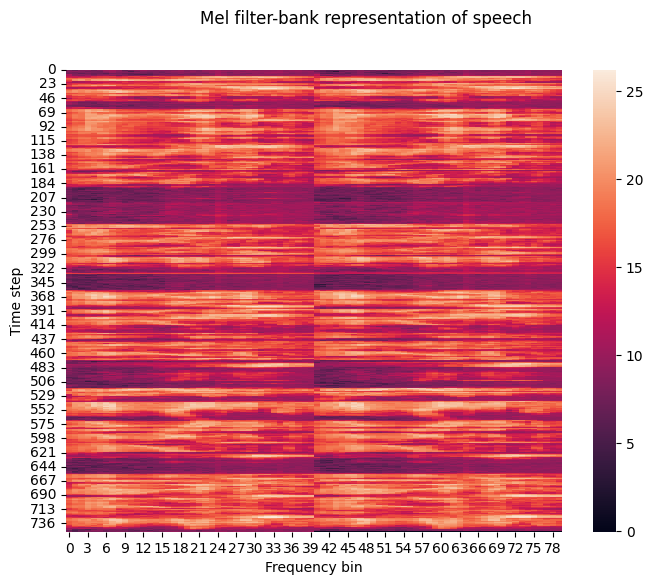

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
plt.suptitle("Mel filter-bank representation of speech")

ax = sns.heatmap(fbank_feats)
ax.set(xlabel='Frequency bin', ylabel='Time step')

plt.show()

#### Pre-training targets

In our pre-training setup for low-resource languages, we won't be using as strict of a cramming criteria in that we'll be using some pseudolabels generated by a larger teacher model. The pre-training targets are derived by using a k-means model to cluster speech embeddings (some middle layer of a large transformer model) derived from a larger teacher model.

All we need to know for this set of notebooks is that the pre-training targets have the same number of time steps as the input feature matrix and the 'vocabulary size' is 512 (number of clusters of the k-means model).

In [7]:
ptlabels = train_cuts[0].load_custom('ptlabel')

# Recall fbank_feats.shape is (750, 80)
ptlabels.shape

(750,)

In [8]:
# List the first 100 pre-training targets
ptlabels[:100]

array([240,  50, 420,  50, 420, 222, 344, 504, 504, 190, 504, 351, 351,
       236, 484, 484, 398, 398, 128, 413, 102, 351, 351, 437, 437, 437,
       437, 205, 241,  17,  17, 184, 484, 484, 398, 398, 398, 291, 114,
       378, 378, 360, 298, 478, 478, 478, 212, 199, 316, 316, 316, 316,
       316, 336,  16, 358,  16, 358, 434, 190,  28, 500, 114, 274, 134,
       134,  55, 460, 348, 155, 155,  33,  15, 406, 461, 461, 461, 391,
        71,  41, 390, 158,  18, 400,  39, 492,  54,  54, 257, 257, 363,
       155,  37, 489, 268, 268, 268, 268, 268,  71], dtype=int32)

### Configure data loader

Now that we've inspected a single Cut, we can configure a vanilla PyTorch dataloader with some Lhotse helpers to fetch batches of Cuts, where the batch size is a set of randomly sampled Cuts whose total combined length is of a certain duration (notice the `max_duration` parameter in the `DynamicBucketingSampler`).

In [9]:
from lhotse.dataset import DynamicBucketingSampler
from lhotse.dataset.collation import collate_custom_field
from torch.utils.data import Dataset, DataLoader

train_sampler = DynamicBucketingSampler(
    train_cuts,
    # Dynamically sample items that
    # altogther add up to 60 seconds
    max_duration=60
  )

class HuBERTPretrainingDataset(Dataset):
    def __getitem__(self, cuts: CutSet) -> dict:
        cuts = cuts.sort_by_duration()

        # Collate and pad
        feats_padded, feat_lens = collate_custom_field(cuts, 'fbank', pad_value=0)
        # Note we'll use a negative integer for padding the labels since 0 is a valid label
        ptlabels_padded, ptlabels_lengths = collate_custom_field(cuts, 'ptlabel', pad_value=-100)

        return {"feats_padded": feats_padded, "feat_lens": feat_lens, "ptlabels_padded": ptlabels_padded, "ptlabels_lengths": ptlabels_lengths}

train_loader = DataLoader(
    HuBERTPretrainingDataset(),
    sampler=train_sampler,
    batch_size=None,
    num_workers=1
)

The data returned for each batch by the dataloader is configured (by us) by defining the `__getitem__` method in the `HuBERTPretrainingDataset`. We use some helpers from Lhotse to collate and pad the feature matrices and labels of the Cuts returned by the sampler.

In [10]:
batch = next(iter(train_loader))

batch

{'feats_padded': tensor([[[ 8.0312,  6.3081,  5.6085,  ...,  9.9287,  9.7825,  9.2193],
          [ 6.0623,  5.5936,  6.3717,  ...,  8.7658,  9.4892,  9.5833],
          [ 6.5774,  5.4523,  7.3200,  ...,  9.1725,  9.9851,  9.9644],
          ...,
          [ 6.8111,  6.4719,  7.3717,  ..., 11.5423, 11.6784, 11.2297],
          [ 6.3828,  7.6254,  8.7734,  ..., 15.8933, 16.1830, 16.0805],
          [ 7.8642,  7.3241,  8.9053,  ..., 11.0786, 10.8585, 10.8489]],
 
         [[ 8.3438,  7.9204,  7.6191,  ...,  9.3661,  9.0802,  8.9283],
          [ 8.0286,  6.6956,  8.4073,  ...,  9.4909,  9.6967,  8.9417],
          [ 8.9658,  9.1295,  8.5936,  ...,  9.2658,  9.3963,  9.5405],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
 
         [[ 8.1562,  6.2256,  5.9716,  ...,  9.9072,  9.6092,  9.2015],
          [ 

## Vanilla HuBERT encoder

Now that we've looked at some data, let's take a look at a forward pass and loss calculation using the base-sized vanilla HuBERT encoder. Some notes:

- The encoder includes the feature projection layer which takes our input features of dimension 80 and projects them to 768 to match the inner dimension of the encoder layers
- Unlike the vanilla BERT model, the vanilla HuBERT model uses a learned `ConvolutionalPositionalEmbedding` layer for positional encoding. This seems to have originated in [this FAIR paper](https://arxiv.org/pdf/1904.11660.pdf) and inherited in all the subsequent work including wav2vec 2.0 and HuBERT.

In [11]:
from components.model import get_torchaudio_hubert_pretrain_base_encoder

vanilla_hubert_base = get_torchaudio_hubert_pretrain_base_encoder()

vanilla_hubert_base

Encoder(
  (feature_projection): FeatureProjection(
    (layer_norm): LayerNorm((80,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=80, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (pos_conv_embed): ConvolutionalPositionalEmbedding(
      (conv): Conv1d(768, 768, kernel_size=(128,), stride=(1,), padding=(64,), groups=16)
    )
    (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (layers): ModuleList(
      (0-11): 12 x EncoderLayer(
        (attention): SelfAttention(
          (k_proj): Linear(in_features=768, out_features=768, bias=True)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.1, inplace=False)
        (la

### Data pre-processing

To pass our `batch` of data into this encoder, we'll need to do some pre-processing. First we use the `_get_padding_mask` function to calculate the time steps in each Cut that is padding so they are not involved the pre-training masking.

In [12]:
from components.verbatim_torchaudio import _get_padding_mask, _compute_mask_indices

padding_mask = _get_padding_mask(batch['feats_padded'], batch['feat_lens'])

padding_mask

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True]])

Next we use the `_compute_mask_indices` function to generate some indices of time steps to mask for each Cut in the batch.

In [13]:
B, T, C = batch['feats_padded'].shape

masks_for_modeling = _compute_mask_indices(
    (B, T),
    padding_mask,
    # Use HuBERT defaults
    mask_prob=0.8,
    mask_length=10,
    mask_type='static',
    mask_other=0.0,
    min_masks=2,
    no_overlap=False,
    min_space=1,
)

masks_for_modeling

tensor([[False, False, False,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [False, False,  True,  ..., False, False, False]])

The following visualizations show how the input feature matrix is changed after certain time frames are zeroed out by the masking.

<Axes: title={'center': 'Masked features for utterance 1'}>

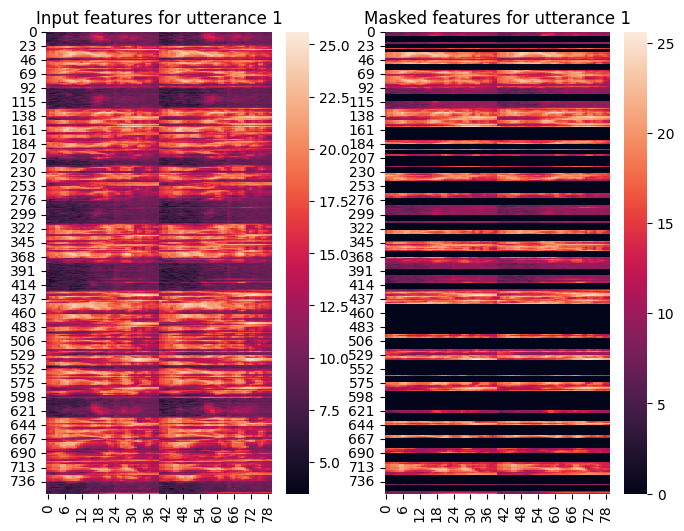

In [14]:
# Make a copy just for this demo
unmasked_feats = batch['feats_padded'].clone()

# Zero-out random frames
batch['feats_padded'][masks_for_modeling] = 0

fig, axes = plt.subplots(1, 2, figsize=(8,6))

axes[0].set_title('Input features for utterance 1')
sns.heatmap(unmasked_feats[0].detach().numpy(), ax=axes[0])

axes[1].set_title('Masked features for utterance 1')
sns.heatmap(batch['feats_padded'][0].detach().numpy(), ax=axes[1])

### Run forward pass

As expected, we get a tensor of shape `(B, T, H)` where `B` is the batch size, `T` is the number of time steps of the longest Cut in the batch, and `H` is the hidden dimensions of our vanilla HuBERT base encoder (i.e. 768).

In [15]:
transformer_outputs = vanilla_hubert_base(batch['feats_padded'], batch['feat_lens'])

In [16]:
transformer_outputs.shape

torch.Size([3, 756, 768])

### Data post-processing

Note the encoder block doesn't include the final projection for calculating the pre-training loss. From the `torchaudio` codebase, it seems that the masked and unmasked frames are seperated passed into the final projection layer as follows:

In [17]:
import torch

# Which frames are NOT padding, but masked from the transformer?
mask_m = torch.logical_and(~padding_mask, masks_for_modeling)

final_proj = torch.nn.Linear(768, 512)

# Calculate logits for masked frames
logits_m = final_proj(transformer_outputs[mask_m])

# Calculate logits for unmasked frames
logits_u = final_proj(transformer_outputs[~mask_m])

### Calculate pre-training loss

For the loss, we use the `torch.nn.CrossEntropyLoss()` and weight the masked and unmaksed frames differently. From the original HuBERT paper they found that the best weights were `1.0` and `0.0`, respectively. That is, we only care about the masked frames.

In a sense, for masked language modeling such as `'The ___ in the hat'`, we only care about whether the masked word in `___` (e.g. `man`) is correctly guessed.

In [18]:
# Adapted from https://github.com/pytorch/audio/blob/0688863cec57675c42db6802c85056fd2bcaaf0c/examples/self_supervised_learning/losses/_hubert_loss.py
class HuBERTPretrainingLoss(torch.nn.Module):

  def __init__(self, label_pad_index=-100, pred_masked_weight=1.0, pred_nomask_weight=0.0):
    super().__init__()

    self.ce_loss = torch.nn.CrossEntropyLoss(ignore_index=label_pad_index, reduction="sum")
    self.pred_masked_weight = pred_masked_weight
    self.pred_nomask_weight = pred_nomask_weight

  def forward(self, logits_m, logits_u, masks_for_modeling, ptlabels_padded):
    loss = 0.0

    if logits_m != None and self.pred_masked_weight > 0:
      labels_m = ptlabels_padded[masks_for_modeling]
      loss += self.pred_masked_weight * self.ce_loss(logits_m, labels_m)

    if logits_u != None and self.pred_nomask_weight > 0:
      labels_u = ptlabels_padded[~masks_for_modeling]
      loss += self.pred_nomask_weight * self.ce_loss(logits_u, labels_u)

    return loss

In [19]:
hubert_pt_loss = HuBERTPretrainingLoss()

loss = hubert_pt_loss(
    logits_m,
    logits_u,
    masks_for_modeling,
    batch["ptlabels_padded"]
)

loss

tensor(8060.6592, grad_fn=<AddBackward0>)